In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [6]:
df_sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
print(df_sample.head())
print(df_sample.shape)

        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0
(28512, 2)


In [7]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

df_holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [8]:
# check train data
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [20]:
df_train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [22]:
print(df_test.head())
print(df_test.tail())

        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0
            id        date  store_nbr                      family  onpromotion
28507  3029395  2017-08-31          9                     POULTRY            1
28508  3029396  2017-08-31          9              PREPARED FOODS            0
28509  3029397  2017-08-31          9                     PRODUCE            1
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399  2017-08-31          9                     SEAFOOD            0


In [9]:
df_train.shape

(3000888, 6)

In [11]:
# check if there is any missing value
df_train.isnull().sum()
# no missing values

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### Oil price dependency: Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [12]:
print(f"dimention of oil data: {df_oil.shape}")

dimention of oil data: (1218, 2)


In [56]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [49]:
df_oil.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [57]:
# There should be 1703 days between 2013-01-01 and 2017-08-31
# But There are lots of missing values
len(df_oil.groupby("date")["dcoilwtico"].sum())

1218

In [16]:
# check empty data in oil
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [37]:
df_oil[df_oil['dcoilwtico'] == 0]

,date,dcoilwtico


In [52]:
df_oil[df_oil["date"].isnull()]

,date,dcoilwtico


In [30]:
# sporadic oil missingg values
df_oil[df_oil["dcoilwtico"].isnull()]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


Text(0, 0.5, 'Oil price')

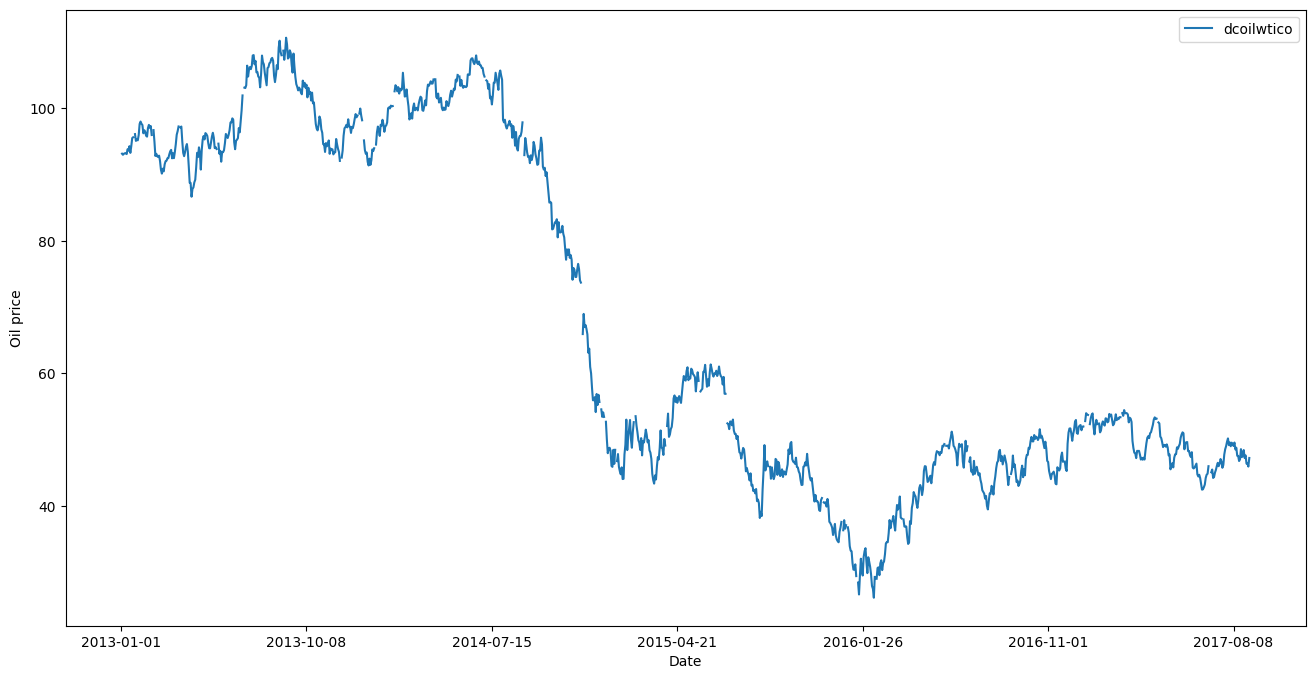

In [23]:
# oil data
ax = df_oil.set_index("date").plot(figsize = (16, 8))
ax.set_xlabel("Date")
ax.set_ylabel("Oil price")

In [69]:
# Import 
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
print(oil.shape)

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
print(oil.shape)
# oil.head()
# print(oil.isnull().sum())
# print(oil.shape)

# print(oil[oil["dcoilwtico"] == 0].shape)

# oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
# print(oil.isnull().sum())
# print(oil.shape)

# print(oil)

(1218, 2)
(1704, 2)


In [70]:
oil.head()

,date,dcoilwtico
0,2013-01-01,0.00
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,0.00


Text(0, 0.5, 'Oil price')

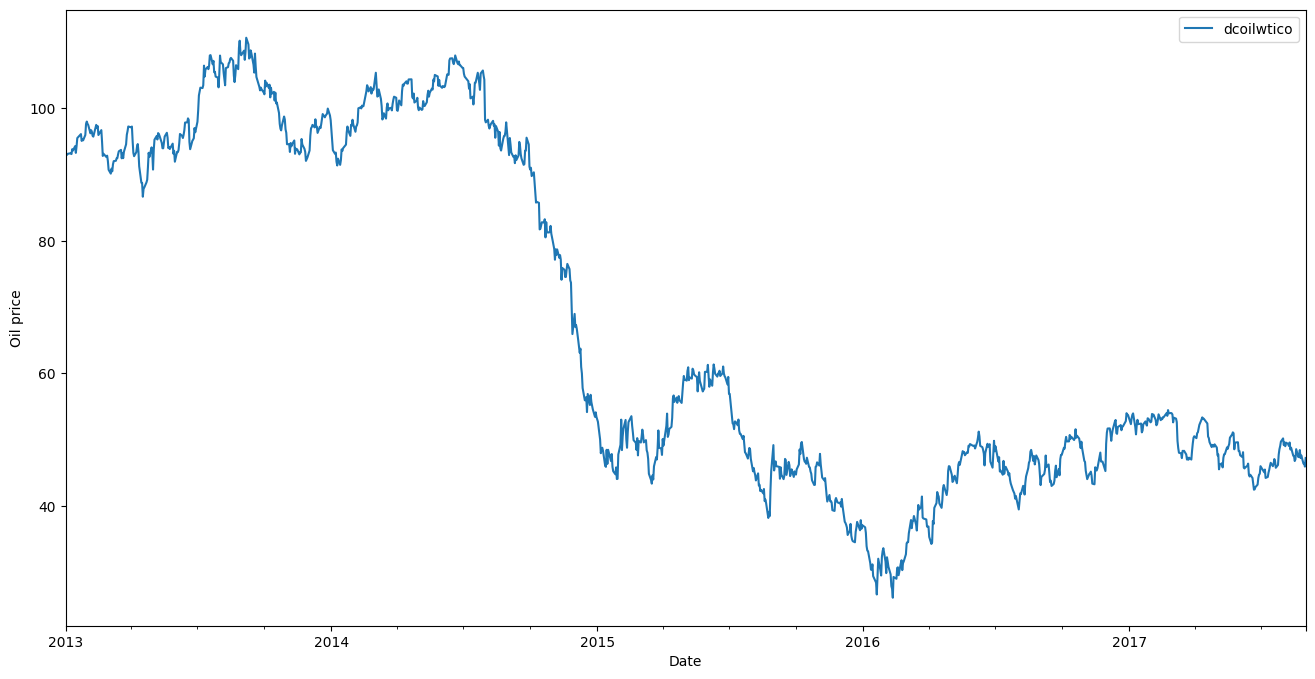

In [8]:
# oil data
ax = oil.set_index("date").plot(figsize = (16, 8))
ax.set_xlabel("Date")
ax.set_ylabel("Oil price")

In [18]:
import pandas as pd
import numpy as np
import plotly.express as px

# Import
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil["date"])

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum()

# Replace 0s with NaN
oil = oil.replace(0, np.nan)

# Interpolate
oil_interpolated = oil.interpolate(method="time")

# Reset index to bring 'date' back as a column
oil = oil_interpolated.reset_index()

# Plot
p = oil.melt(id_vars=["date"], var_name="Legend", value_name="value")
# fig = px.line(p.sort_values(["Legend", "date"], ascending=[False, True]),
#               x="date", y="value", color="Legend", title="Daily Oil Price")
# fig.show()

fig = px.line(p.sort_values(["Legend", "date"], ascending=[False, True]), x="date", y="value", color="Legend", title="Daily Oil Price")
fig.show(renderer='iframe')

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Import
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil["date"])

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()

# Replace 0s with NaN
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])

# Interpolate
oil["dcoilwtico_interpolated"] = oil["dcoilwtico"].interpolate()

# Melt data for plotting
p = oil.melt(id_vars=["date"], value_vars=["dcoilwtico", "dcoilwtico_interpolated"],
             var_name="Legend", value_name="value")

# Plot
fig = px.line(p.sort_values(["Legend", "date"], ascending=[False, True]),
              x="date", y="value", color="Legend", title="Daily Oil Price")
fig.show(renderer='iframe')

In [25]:
# Import 
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
fig = px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price")
fig.show(renderer='iframe')

In [26]:
# Import
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import pandas as pd
import numpy as np
import plotly.express as px

# Load Data
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil["date"])

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()

# Replace 0s with NaN
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])

# Time-Based Interpolation
oil = oil.set_index("date")  # Set 'date' as index for time-based interpolation
oil["dcoilwtico_interpolated_2"] = oil["dcoilwtico"].interpolate(method="time")
oil = oil.reset_index()  # Reset index to restore original structure

# Plot
p = oil.melt(id_vars=["date"], value_vars=["dcoilwtico", "dcoilwtico_interpolated_2"], 
             var_name="Legend", value_name="value")

fig = px.line(p.sort_values(["Legend", "date"], ascending=[False, True]), 
              x="date", y="value", color="Legend", title="Daily Oil Price")
fig.show(renderer='iframe')


,date,dcoilwtico,dcoilwtico_interpolated_2
0,2013-01-01,NaN,NaN
1,2013-01-02,93.14,93.140000
2,2013-01-03,92.97,92.970000
3,2013-01-04,93.12,93.120000
4,2013-01-05,NaN,93.146667
...,...,...,...
1699,2017-08-27,NaN,46.816667
1700,2017-08-28,46.40,46.400000
1701,2017-08-29,46.46,46.460000
1702,2017-08-30,45.96,45.960000


In [14]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [15]:
df_holidays.shape

(350, 6)

In [16]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [17]:
df_oil.shape

(1218, 2)

In [18]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
df_stores.shape

(54, 5)

In [30]:
df_transactions.head(-5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83478,2017-08-15,45,3685
83479,2017-08-15,46,3197
83480,2017-08-15,47,3581
83481,2017-08-15,48,2722


In [21]:
df_transactions.shape

(83488, 3)

In [24]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [29]:
df_train.head(-5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000878,3000878,2017-08-15,9,MAGAZINES,11.000,0
3000879,3000879,2017-08-15,9,MEATS,449.228,0
3000880,3000880,2017-08-15,9,PERSONAL CARE,522.000,11
3000881,3000881,2017-08-15,9,PET SUPPLIES,6.000,0
